## Skin Cancer Detection¶
#### Project description
Skin cancer is the most common form of cancer, globally accounting for at least 40% of cancer cases. People with lighter skin are at higher risk. There are three main types of skin cancers: basal-cell skin cancer (BCC), squamous-cell skin cancer (SCC), and melanoma. Globally in 2012, melanoma occurred in 232,000 people and resulted in 55,000 deaths. Between 20% and 30% of melanomas develop from moles.

#### Task
In this project, we will develop deep learning-based solutions to classify images of skin moles into benign or malignant categories.

#### Data
The training and test set contains 2,637 and 660 images, respectively. The dataset is from a Kaggle Competition at https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign. The 'data' folder structure is as below

- data
    - train
        - benign
        - malignant
    - test
        - benign
        - malignant

#### Code templates
- If you have a computer with a large-size RAM (>8GB) and a fast CPU, you can download the data(zip file) to work on your own computer. You need to manually unzip the data file.
 - If you would like to use google colab, you can download the 'colab' template, and upload the code file and data zip file to your Google Drive; then open and edit the code using the Google Colab. The 3rd code cell will unzip the data file automatically.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [4]:
import zipfile
import os

os.makedirs("/content/", exist_ok=True)

with zipfile.ZipFile("/content/data.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

print("Unzip successful!")


Unzip successful!


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [7]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 1. Data preparation

In [8]:
import os
from PIL import Image

#1.1 get image lists
train_b = 'data/train/benign'
train_m = 'data/train/malignant'

test_b = 'data/test/benign'
test_m = 'data/test/malignant'

def getImList(folder):
    # get the list of file names in 'folder'
    imList = os.listdir(folder) # get all names
    fPath = [os.path.join(folder, fName) for fName in imList] # add path to names

    return fPath

trainList_b = getImList(train_b)
trainList_m = getImList(train_m)
trainList = trainList_b + trainList_m
print("# training images:", len(trainList))

testList_b = getImList(test_b)
testList_m = getImList(test_m)
testList = testList_b + testList_m
print("# test images:", len(testList))

#1.2 load all images
read = lambda imName: np.asarray(Image.open(imName).convert("RGB"))
print('loading images ...')
X_train = [read(name) for name in trainList]
X_train = np.array(X_train, dtype='uint8')/255
print('.   training set shape:', X_train.shape)

X_test = [read(name) for name in testList]
X_test = np.array(X_test, dtype='uint8')/255
print('.   test set shape:', X_test.shape)

print('loading ended.')

# 1.3 Create target labels
y_benign_train = np.zeros(len(trainList_b))
y_malignant_train = np.ones(len(trainList_m))
y_train = np.concatenate((y_benign_train, y_malignant_train), axis = 0)
print('.    training target shape: ', y_train.shape)
y_benign_test = np.zeros(len(testList_b))
y_malignant_test = np.ones(len(testList_m))
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)
print('.    test target shape', y_test.shape)

# 1.4 Shuffle data
print('shuffling data ...')
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

print('Dataset is ready for using.')


# training images: 2637
# test images: 660
loading images ...
.   training set shape: (2637, 224, 224, 3)
.   test set shape: (660, 224, 224, 3)
loading ended.
.    training target shape:  (2637,)
.    test target shape (660,)
shuffling data ...
Dataset is ready for using.


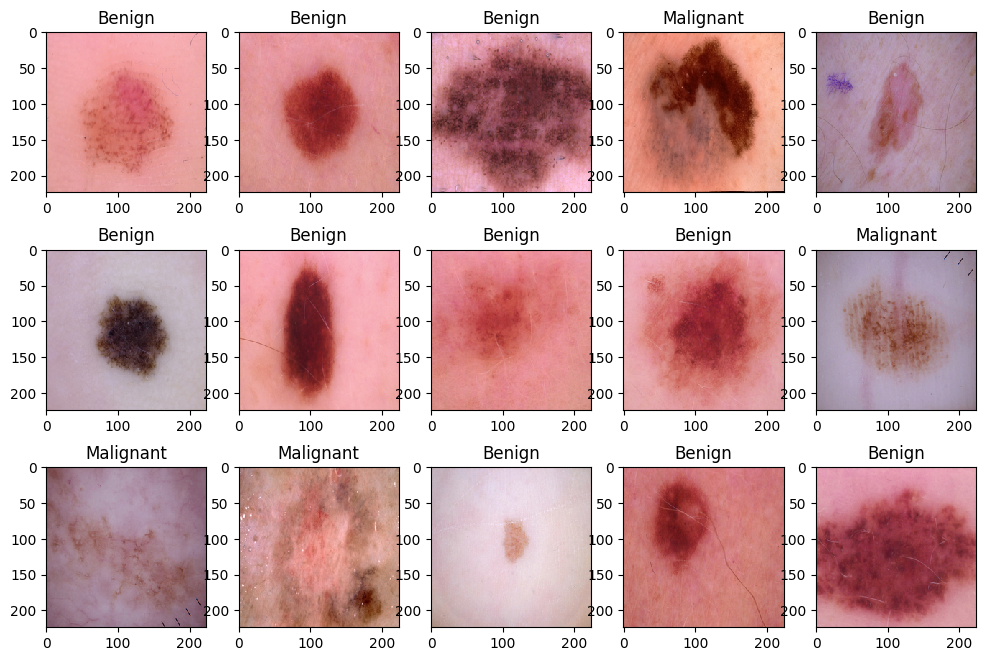

In [9]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [11]:
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (2109, 224, 224, 3) (2109,)
Val  : (528, 224, 224, 3) (528,)
Test : (660, 224, 224, 3) (660,)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    horizontal_flip=True
)

val_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_flow = train_gen.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True)
val_flow   = val_gen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_flow  = test_gen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
def build_baseline_cnn(input_shape=(224,224,3)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

cnn_model = build_baseline_cnn()
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

cnn_callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_cnn.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
]

history_cnn = cnn_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=20,
    callbacks=cnn_callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6252 - auc: 0.6574 - loss: 0.9060
Epoch 1: val_accuracy improved from -inf to 0.77083, saving model to best_cnn.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.6263 - auc: 0.6589 - loss: 0.9022 - val_accuracy: 0.7708 - val_auc: 0.8515 - val_loss: 0.4547 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7595 - auc: 0.8413 - loss: 0.4733
Epoch 2: val_accuracy did not improve from 0.77083
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.7597 - auc: 0.8415 - loss: 0.4731 - val_accuracy: 0.6894 - val_auc: 0.8526 - val_loss: 0.6296 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7764 - auc: 0.8440 - loss: 0.4828
Epoch 3: val_accuracy improved from 0.77083 to 0.78220, saving model to best_cnn.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.7764 - auc: 0.8442 - loss: 0.4823 - val_accuracy: 0.7822 - val_auc: 0.8911

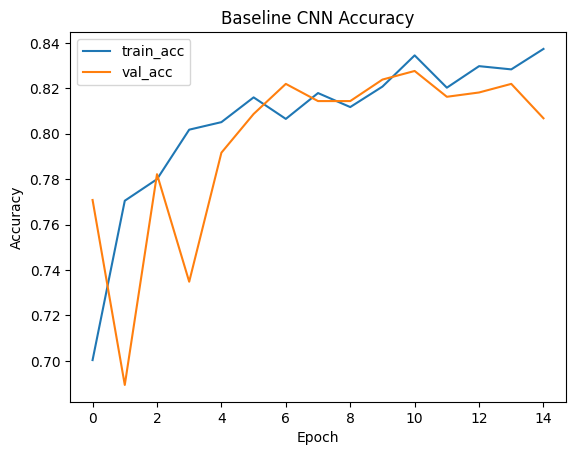

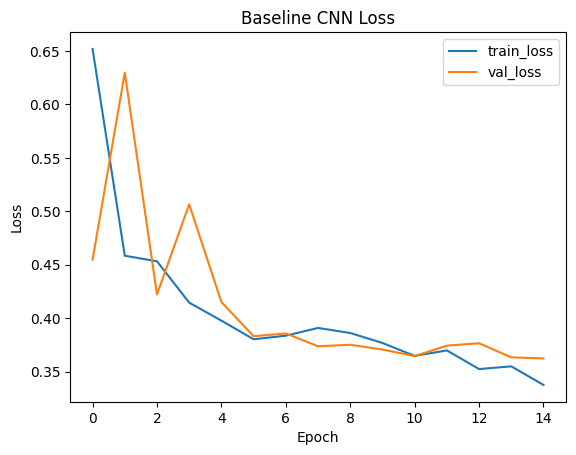

In [15]:
plt.figure()
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.title("Baseline CNN Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.show()

plt.figure()
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.title("Baseline CNN Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()

In [17]:
cnn_probs = cnn_model.predict(test_flow).reshape(-1)
cnn_pred  = (cnn_probs >= 0.5).astype(int)

cnn_acc = accuracy_score(y_test.astype(int), cnn_pred)
print("Baseline CNN Test Accuracy:", cnn_acc*100)

print("\nClassification Report (Baseline CNN):")
print(classification_report(y_test.astype(int), cnn_pred, target_names=["Benign", "Malignant"]))

cm = confusion_matrix(y_test.astype(int), cnn_pred)
print("Confusion Matrix:\n", cm)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Baseline CNN Test Accuracy: 83.18181818181817

Classification Report (Baseline CNN):
              precision    recall  f1-score   support

      Benign       0.90      0.78      0.84       360
   Malignant       0.77      0.89      0.83       300

    accuracy                           0.83       660
   macro avg       0.84      0.84      0.83       660
weighted avg       0.84      0.83      0.83       660

Confusion Matrix:
 [[281  79]
 [ 32 268]]


In [19]:
report = classification_report(
    y_test.astype(int),
    cnn_pred,
    target_names=["Benign", "Malignant"],
    output_dict=True
)

import pandas as pd
df_report = pd.DataFrame(report).transpose()
df_report


,precision,recall,f1-score,support
Benign,0.897764,0.780556,0.835067,360.000000
Malignant,0.772334,0.893333,0.828439,300.000000
accuracy,0.831818,0.831818,0.831818,0.831818
macro avg,0.835049,0.836944,0.831753,660.000000
weighted avg,0.840750,0.831818,0.832054,660.000000


ResNet50 Transfer Learning

In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input

X_tr_r  = preprocess_input((X_tr * 255).astype("float32"))
X_val_r = preprocess_input((X_val * 255).astype("float32"))
X_test_r= preprocess_input((X_test* 255).astype("float32"))


In [21]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling="avg"
)

base_model.trainable = False  # CRITICAL


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

resnet_model = keras.Model(inputs, outputs)
resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_r1 = resnet_model.fit(
    X_tr_r, y_tr,
    validation_data=(X_val_r, y_val),
    epochs=8,
    batch_size=32,
    verbose=1
)


Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 317ms/step - accuracy: 0.6995 - loss: 0.6696 - val_accuracy: 0.8352 - val_loss: 0.3509
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8548 - loss: 0.3141 - val_accuracy: 0.8598 - val_loss: 0.3149
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8819 - loss: 0.2683 - val_accuracy: 0.8447 - val_loss: 0.3140
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8741 - loss: 0.2583 - val_accuracy: 0.8636 - val_loss: 0.3023
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9011 - loss: 0.2150 - val_accuracy: 0.8655 - val_loss: 0.3116
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9071 - loss: 0.2084 - val_accuracy: 0.8636 - val_loss: 0.3009
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9246 - loss: 0.1788 - val_accuracy: 0.8731 - val_loss: 0.3012
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9275 - loss: 0.1742 - val_accuracy: 0.8712 - val_los

Fine-tune last layers

In [24]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


In [25]:
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_r2 = resnet_model.fit(
    X_tr_r, y_tr,
    validation_data=(X_val_r, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 357ms/step - accuracy: 0.7522 - loss: 0.6801 - val_accuracy: 0.8598 - val_loss: 0.3920
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9171 - loss: 0.1938 - val_accuracy: 0.8750 - val_loss: 0.3178
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9538 - loss: 0.1251 - val_accuracy: 0.8807 - val_loss: 0.3100
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9810 - loss: 0.0760 - val_accuracy: 0.8845 - val_loss: 0.3195
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9838 - loss: 0.0577 - val_accuracy: 0.8864 - val_loss: 0.3299
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9944 - loss: 0.0352 - val_accuracy: 0.8826 - val_loss: 0.3454
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9955 - loss: 0.0248 - val_accuracy: 0.8845 - val_loss: 0.3703
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9996 - loss: 0.0162 - val_accuracy: 0

In [26]:
resnet_pred = (resnet_model.predict(X_test_r) > 0.5).astype(int)
resnet_acc = accuracy_score(y_test, resnet_pred)

print("ResNet50 Test Accuracy:", resnet_acc*100)


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step
ResNet50 Test Accuracy: 88.03030303030303


In [27]:
from sklearn.metrics import classification_report

print("Classification Report (ResNet50):")
print(
    classification_report(
        y_test.astype(int),
        resnet_pred,
        target_names=["Benign", "Malignant"]
    )
)


Classification Report (ResNet50):
              precision    recall  f1-score   support

      Benign       0.91      0.86      0.89       360
   Malignant       0.85      0.90      0.87       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660



In [28]:
report = classification_report(
    y_test.astype(int),
    resnet_pred,
    target_names=["Benign", "Malignant"],
    output_dict=True
)

import pandas as pd
df_report = pd.DataFrame(report).transpose()
df_report


,precision,recall,f1-score,support
Benign,0.912023,0.863889,0.887304,360.000000
Malignant,0.846395,0.900000,0.872375,300.000000
accuracy,0.880303,0.880303,0.880303,0.880303
macro avg,0.879209,0.881944,0.879839,660.000000
weighted avg,0.882192,0.880303,0.880518,660.000000


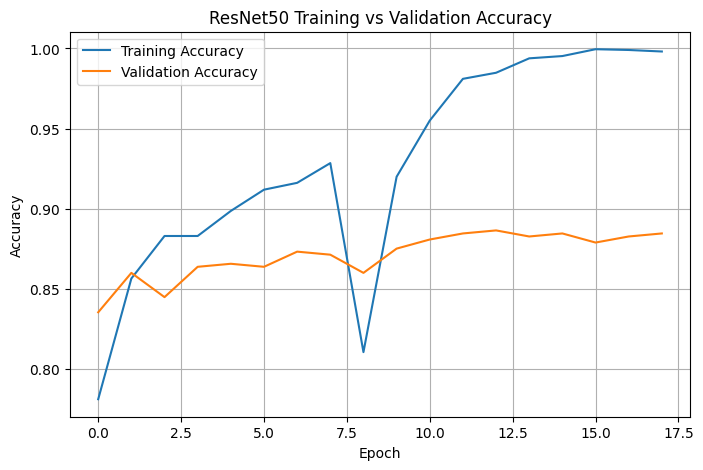

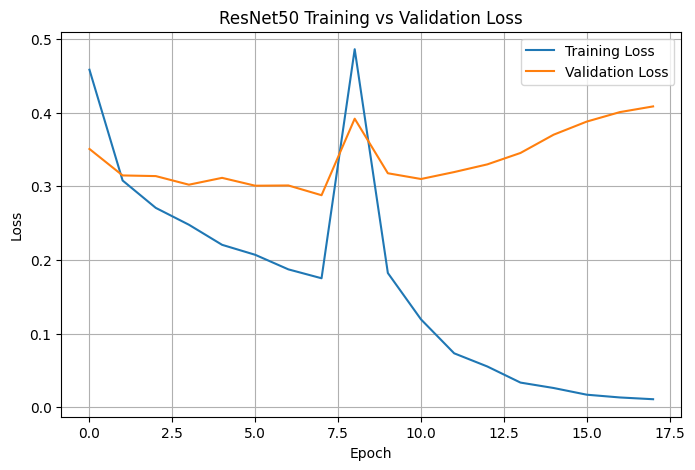

In [29]:
# Combine histories (head training + fine-tuning)
acc = history_r1.history['accuracy'] + history_r2.history['accuracy']
val_acc = history_r1.history['val_accuracy'] + history_r2.history['val_accuracy']

plt.figure(figsize=(8,5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

loss = history_r1.history['loss'] + history_r2.history['loss']
val_loss = history_r1.history['val_loss'] + history_r2.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



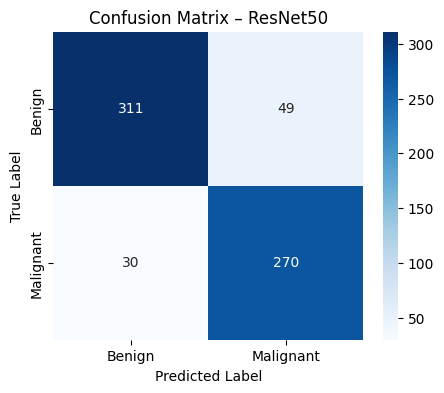

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.astype(int), resnet_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Benign', 'Malignant'],
    yticklabels=['Benign', 'Malignant']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – ResNet50')
plt.show()


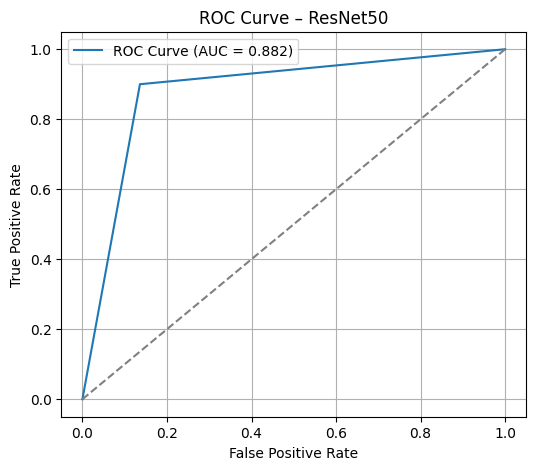

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, resnet_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – ResNet50')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Mean Accuracy Error
mean_accuracy_error = 1.0 - resnet_acc
print("Mean Accuracy Error (MAE):", mean_accuracy_error)



Mean Accuracy Error (MAE): 0.11969696969696975
